In [521]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter
from shapely.geometry import Point

# Load dataset
airlines = pd.read_csv('airlines.csv')
airports = pd.read_csv('airports.csv')
delay = pd.read_csv('delay.csv')
flights_details = pd.read_csv('flights_details.csv', parse_dates=["departure_time", "arrival_time"])
flights_info = pd.read_csv('flights_info.csv')
planes = pd.read_csv('planes.csv', sep=";")

### Préparation des données  
Dans cette section, certaines colonnes seront converties en types de données adéquats et la présence de lignes en double sera vérifiée.
Ensuite, on explorera les données en faisant attention à d'éventuelles valeur manquantes.

*Remarque : cette section présente des transformations de données. Les lecteurs qui ne sont pas intéressés par ces détails techniques peuvent passer directement à la section suivante de ce rapport.

In [522]:
# Convert data
delay["delay"]=pd.to_timedelta(delay.delay+":00")                   # duration type
flights_details = flights_details.astype({'status': 'category'})

In [523]:
# Dictionary for dataframes
dataframes= {'airlines': airlines, 'airports': airports, 'delay': delay, 
            'flights_details': flights_details, 'flights_info': flights_info, 'planes': planes}

# Check for duplicate values
for name, df in dataframes.items():
    print(f"DataFrame: {name} - {df.duplicated().sum()} duplicate values")

DataFrame: airlines - 2 duplicate values
DataFrame: airports - 0 duplicate values
DataFrame: delay - 0 duplicate values
DataFrame: flights_details - 0 duplicate values
DataFrame: flights_info - 0 duplicate values
DataFrame: planes - 0 duplicate values


Il semble qu'il y ait des valeurs en double dans la base de données *airlines*. Regardons ça de plus près:

In [524]:
# Investigation duplicate values
airlines.loc[airlines.duplicated( keep=False)]

,airline_id,airline_name,country
161,AGO,Angola Air Charter,Angola
162,AGO,Angola Air Charter,Angola
2272,EJA,NetJets,United States
3586,EJA,NetJets,United States


Supprimer les lignes en double ne devrait pas impacter notre analyse. Cette base de données donne juste des précisisions sur les compagnies aériennes (id, nom et pays).

In [525]:
# Remove duplicate rows
airlines.drop_duplicates(inplace=True)

# Verify that there is no more duplicate values
assert airlines.duplicated().any() == False

In [526]:
# Check for duplicate values
for name, df in dataframes.items():
    print(f"DataFrame: {name}")
    print(f"{df.isna().sum()} missing values")
    print("\n")

DataFrame: airlines
airline_id      0
airline_name    0
country         5
dtype: int64 missing values


DataFrame: airports
airport_id       0
airport_name     0
city            49
country          0
latitude         0
longitude        0
dtype: int64 missing values


DataFrame: delay
flight_id    0
delay        0
dtype: int64 missing values


DataFrame: flights_details
flight_id          0
departure_time     0
arrival_time       0
passenger_count    0
status             0
dtype: int64 missing values


DataFrame: flights_info
flight_id                  0
flight_number             20
origin_airport_id          0
destination_airport_id     0
airline_id                12
plane_id                   0
dtype: int64 missing values


DataFrame: planes
plane_id            0
manufacturer        0
model               0
seating_capacity    0
dtype: int64 missing values




Il y a 3 base de données avec des valeurs manquantes:
- *airlines* où la *country* n'est pas complète
- *airports* où la colonne *city* n'est pas complète
- *flights_info*  où les colonnes *flight_number* et *airline_id* ne sont pas complètes  

En faisait quelques recherches, il devrait être possible de remplir les trous des 2 premières bases de données citées. En revanche, aucune solution ne semble être envisable pour *flights_info*.

In [527]:
# Filling missing values airlines
print(airlines.loc[airlines.country.isna()])

# Create a mapping dictionary for airlines and their countries
country_mapping = {
        'ARJ': 'Costa Rica',
        'BVU': 'Nigeria',
        'GUF': 'Gambia',
        'YYY': 'Canada',
        'MFT': 'United Kingdom'
    }

for id, country in country_mapping.items():
    airlines.loc[airlines.airline_id==id]=airlines.loc[airlines.airline_id==id].fillna({'country':country})
    print(airlines.loc[airlines.airline_id==id])
    print("\n")

# Verify airlines no more duplicate values
assert airlines.duplicated().any() == False

     airline_id                    airline_name country
406         ARJ           Aerojet de Costa Rica     NaN
1492        BVU               Bellview Airlines     NaN
2606        GUF  Gulf African Airlines - Gambia     NaN
2767        YYY                            ICAO     NaN
3510        MFT                     Multiflight     NaN
    airline_id           airline_name     country
406        ARJ  Aerojet de Costa Rica  Costa Rica


     airline_id       airline_name  country
1492        BVU  Bellview Airlines  Nigeria


     airline_id                    airline_name country
2606        GUF  Gulf African Airlines - Gambia  Gambia


     airline_id airline_name country
2767        YYY         ICAO  Canada


     airline_id airline_name         country
3510        MFT  Multiflight  United Kingdom




In [528]:
# Filling missing values airlines
print(airports.loc[airports.city.isna()])

# Create a mapping
city_mappings = {
        'EPMM': 'Minsk Mazowiecki',
        'EPPW': 'Powidz',
        'OEDM': 'Dammam',  # King Salman Abdulaziz Airport location
        'OEKM': 'Khamis Mushait',  # King Khaled Air Base location
        'RJCA': 'Asahikawa',
        'RJTU': 'Utsunomiya',
        'RKTI': 'Chungju',
        'RPMF': 'Bislig',
        'RPMQ': 'Mati',
        'SVMP': 'Caracas',  # Metropolitano Airport location
        'UESG': 'Belaya Gora',
        'URRY': 'Volgodonsk',
        'VARG': 'Ratnagiri',
        'VIAM': 'Ambala',
        'VISA': 'Sirsa',
        'VIUX': 'Udhampur'
    }

for id, city in city_mappings.items():
    airports.loc[airports.airport_id==id]=airports.loc[airports.airport_id==id].fillna({'city':city})
    print(airports.loc[airports.airport_id==id])
    print("\n")

# Verify airports no more duplicate values
assert airports.duplicated().any() == False


     airport_id                        airport_name city       country  \
7031       EPMM  Minsk Mazowiecki Military Air Base  NaN        Poland   
7032       EPPW            Powidz Military Air Base  NaN        Poland   
7137       OEDM       King Salman Abdulaziz Airport  NaN  Saudi Arabia   
7138       OEKM                King Khaled Air Base  NaN  Saudi Arabia   
7158       RJCA                  Asahikawa Airfield  NaN         Japan   
7160       RJTU                  Utsunomiya Airport  NaN         Japan   
7161       RKTI    Jungwon Air Base/Chungju Airport  NaN   South Korea   
7164       RPMF                      Bislig Airport  NaN   Philippines   
7165       RPMQ               Mati National Airport  NaN   Philippines   
7184       SVMP               Metropolitano Airport  NaN     Venezuela   
7191       UESG                 Belaya Gora Airport  NaN        Russia   
7221       URRY                  Volgodonsk Airport  NaN        Russia   
7233       VARG                   Ratn

In [529]:
#EDA
for name, df in dataframes.items():
    print(f"DataFrame: {name}")
    print("--------------")
    print(df.head())
    print(df.info())
    print("\n")

DataFrame: airlines
--------------
  airline_id                                  airline_name         country
0        GNL                                   135 Airways   United States
1        RNX                                 1Time Airline    South Africa
2        WYT  2 Sqn No 1 Elementary Flying Training School  United Kingdom
3        TFU                               213 Flight Unit          Russia
4        CHD                 223 Flight Unit State Airline          Russia
<class 'pandas.core.frame.DataFrame'>
Index: 5806 entries, 0 to 5807
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   airline_id    5806 non-null   object
 1   airline_name  5806 non-null   object
 2   country       5806 non-null   object
dtypes: object(3)
memory usage: 181.4+ KB
None


DataFrame: airports
--------------
  airport_id                                 airport_name          city  \
0       AYGA                               Go

### 1. Combien y a-t-il de vols en cours et combien de destinations différentes sont desservies ?

In [530]:
# Ongoing flights
Counter(flights_details.status)

Counter({'Estimated': 980,
         'Delayed': 282,
         'Landed': 111,
         'Scheduled': 27,
         'Unknown': 4})

Il n'y a apparemment pas de status *airborne*. Il n'y a donc peut-être aucun vol en cours.

In [531]:
# Number of destination
nber_destination=len(flights_info.destination_airport_id.unique())
print(f"Il y a {nber_destination} destinations differentes.")

Il y a 273 destinations differentes.


### 2. Quelle est la compagnie aérienne avec le plus grand nombre de vols pour une journée donnée ?

In [532]:
# Merge dataset
flights=flights_details.merge(flights_info, on="flight_id")
flights_airlines=flights.merge(airlines, on="airline_id", how="right")
flights_airlines.head()

# Create a departure date column
flights_airlines["departure_date"]=flights_airlines["departure_time"].dt.date

# Pivot table with date in the index
number_derpature=flights_airlines.pivot_table(index="departure_date", columns="airline_name", 
                             values="flight_id", aggfunc="count", fill_value=0, sort=True)

# Number max of flight during a day
number_derpature.values.max()

60

In [533]:
# Day with the biggest number of derpature for a company
print(number_derpature.max(1))
print("\n")
# Company with the highest number of derpature for a day
print(number_derpature.idxmax(axis=1))
print("\n")

departure_date
1970-01-01     2
2024-12-15     7
2024-12-16    60
dtype: int64


departure_date
1970-01-01            DHL Air
2024-12-15      Qatar Airways
2024-12-16    United Airlines
dtype: object




La compagnie américaine *United Airlines* est celle qui a réalisé le plus grand nombre de vols en une journée avec un total de 60 le 16 décembre 2024.

### 3. Quels sont les trois avions les plus utilisés (modèle d'avion) et combien d'heures de vol ont-ils effectuées ?

In [534]:
# Marge datadet
flights_planes=flights_airlines.merge(planes, on="plane_id")
flights_planes.head()


,flight_id,departure_time,arrival_time,passenger_count,status,flight_number,origin_airport_id,destination_airport_id,airline_id,plane_id,airline_name,country,departure_date,manufacturer,model,seating_capacity
0,385cc6c1,2024-12-16 13:17:00+00:00,2024-12-16 14:33:00+00:00,3.0,Landed,AA2317,KDCA,KRDU,AAL,A319,American Airlines,United States,2024-12-16,AIRBUS,Airbus A319,5
1,385cee54,2024-12-15 23:40:00+00:00,2024-12-16 14:30:00+00:00,2.0,Estimated,AA8,YBBN,KDFW,AAL,B789,American Airlines,United States,2024-12-15,BOEING,Boeing 787-9 Dreamliner,2
2,385cf5ee,2024-12-16 01:30:00+00:00,2024-12-16 08:15:00+00:00,108.0,Landed,AA177,KJFK,KSFO,AAL,A321,American Airlines,United States,2024-12-16,AIRBUS,Airbus A321,149
3,385d1ac4,2024-12-16 01:20:00+00:00,2024-12-16 16:05:00+00:00,1.0,Estimated,AA292,KJFK,VIDP,AAL,B789,American Airlines,United States,2024-12-16,BOEING,Boeing 787-9 Dreamliner,2
4,385d34ef,2024-12-16 03:45:00+00:00,2024-12-16 20:15:00+00:00,1.0,Estimated,AA7,KDFW,YBBN,AAL,B789,American Airlines,United States,2024-12-16,BOEING,Boeing 787-9 Dreamliner,2


In [535]:
# The 3 most used planes
flights_planes.pivot_table(index="model", values="flight_id", aggfunc="count").nlargest(3, "flight_id")

,flight_id
model,
Boeing 777-300ER,206
Boeing 787-9 Dreamliner,192
Airbus 350-900,115


In [536]:
# Flights duration
flights_planes["flights_duration"]= flights_planes["arrival_time"]-flights_planes["departure_time"]

flights_planes.loc[flights_planes.model.isin(["Boeing 777-300ER", 
                                              "Boeing 787-9 Dreamliner", 
                                              "Airbus 350-900"])].pivot_table(index="model",
                                                                              values="flights_duration",
                                                                              aggfunc="sum").sort_values("flights_duration", ascending=False)

,flights_duration
model,
Boeing 777-300ER,99 days 14:20:00
Boeing 787-9 Dreamliner,91 days 04:59:00
Airbus 350-900,57 days 10:20:00


### 5. Quelle est la moyenne du nombre de passagers par vol pour chaque compagnie ?

In [537]:
# Number of flight by company
airlines_nb_flights=flights_planes.pivot_table(index="airline_name", values="flight_id", aggfunc="count")
airlines_nb_flights

,flight_id
airline_name,
AC Challenge Aero,2
ACT Havayollari,1
Aer Lingus,1
AeroMéxico,10
Aeroflot Russian Airlines,11
...,...
Volaris,2
WestJet,5
Wizz Air,6


In [538]:
# Number of passenger by company
airlines_passenger=flights_planes.pivot_table(index="airline_name", values="passenger_count", aggfunc="sum")
airlines_passenger

,passenger_count
airline_name,
AC Challenge Aero,17.0
ACT Havayollari,9.0
Aer Lingus,238.0
AeroMéxico,1609.0
Aeroflot Russian Airlines,1442.0
...,...
Volaris,105.0
WestJet,468.0
Wizz Air,152.0


In [539]:
# Average passengers by company
airlines_nb_flights_passenger_count=airlines_nb_flights.merge(airlines_passenger, on="airline_name")
airlines_nb_flights_passenger_count["passenger_mean"]=airlines_nb_flights_passenger_count.passenger_count/airlines_nb_flights_passenger_count.flight_id
print(airlines_nb_flights_passenger_count["passenger_mean"])

airline_name
AC Challenge Aero              8.500000
ACT Havayollari                9.000000
Aer Lingus                   238.000000
AeroMéxico                   160.900000
Aeroflot Russian Airlines    131.090909
                                ...    
Volaris                       52.500000
WestJet                       93.600000
Wizz Air                      25.333333
Xiamen Airlines               99.500000
easyJet                      131.200000
Name: passenger_mean, Length: 189, dtype: float64


### 6. Quel est le numéro du dernier vol pour chaque compagnie aérienne ?

In [540]:
# Time last flight for each company
last_flights=flights_planes.pivot_table(index='airline_name', values='arrival_time', aggfunc='max').reset_index()
last_flights

,airline_name,arrival_time
0,AC Challenge Aero,2024-12-16 18:40:00+00:00
1,ACT Havayollari,2024-12-16 13:25:00+00:00
2,Aer Lingus,2024-12-16 14:30:00+00:00
3,AeroMéxico,2024-12-16 21:50:00+00:00
4,Aeroflot Russian Airlines,2024-12-16 19:10:00+00:00
...,...,...
184,Volaris,2024-12-16 14:57:00+00:00
185,WestJet,2024-12-16 18:36:00+00:00
186,Wizz Air,2024-12-16 15:45:00+00:00
187,Xiamen Airlines,2024-12-16 22:00:00+00:00


In [541]:
# Last flight number for each company
last_flights.merge(flights_planes.loc[:,["airline_name", "arrival_time", "flight_number"]], on=["airline_name", "arrival_time"])

,airline_name,arrival_time,flight_number
0,AC Challenge Aero,2024-12-16 18:40:00+00:00,X7571
1,ACT Havayollari,2024-12-16 13:25:00+00:00,QR8407
2,Aer Lingus,2024-12-16 14:30:00+00:00,EI68
3,AeroMéxico,2024-12-16 21:50:00+00:00,AM2
4,Aeroflot Russian Airlines,2024-12-16 19:10:00+00:00,SU245
...,...,...,...
191,WestJet,2024-12-16 18:36:00+00:00,WS81
192,Wizz Air,2024-12-16 15:45:00+00:00,5W7007
193,Xiamen Airlines,2024-12-16 22:00:00+00:00,MF830
194,Xiamen Airlines,2024-12-16 22:00:00+00:00,MF826


### 7. Quel est le retard moyen pour chaque compagnie aérienne ?

In [542]:
# Checking delay
delay.describe()

,delay
count,283
mean,0 days 14:28:31.590106007
std,0 days 07:01:49.640552749
min,0 days 00:14:00
25%,0 days 08:35:30
50%,0 days 16:09:00
75%,0 days 20:13:30
max,0 days 23:57:00


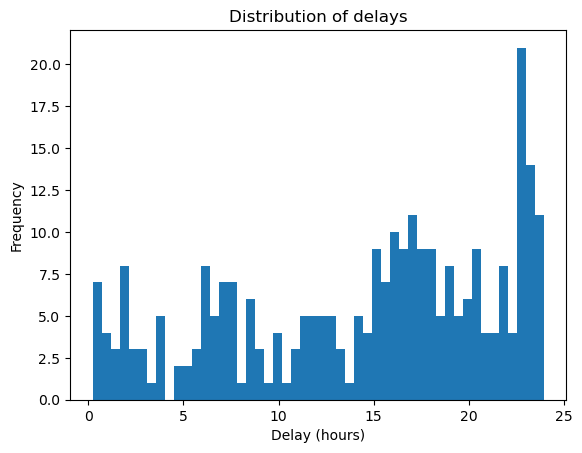

In [543]:
# Convert to hours
delay_hours = delay.delay.dt.total_seconds() / 3600

# Distribution of delays
delay_hours.hist(bins=50, grid=False)
plt.xlabel('Delay (hours)')
plt.ylabel('Frequency')
plt.title('Distribution of delays')
plt.show()


In [544]:
flights_delay=flights_planes.merge(delay, how="left", on="flight_id")
flights_delay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1363 entries, 0 to 1362
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   flight_id               1363 non-null   object             
 1   departure_time          1363 non-null   datetime64[ns, UTC]
 2   arrival_time            1363 non-null   datetime64[ns, UTC]
 3   passenger_count         1363 non-null   float64            
 4   status                  1363 non-null   category           
 5   flight_number           1354 non-null   object             
 6   origin_airport_id       1363 non-null   object             
 7   destination_airport_id  1363 non-null   object             
 8   airline_id              1363 non-null   object             
 9   plane_id                1363 non-null   object             
 10  airline_name            1363 non-null   object             
 11  country                 1363 non-null   obj

In [545]:
# Average delay for each company
flights_delay.pivot_table(index="airline_name", values="delay", aggfunc="mean").sort_values("delay")

,delay
airline_name,
Tiphook PLC,0 days 01:18:00
Lufthansa Cargo,0 days 03:35:00
Juneyao Airlines,0 days 04:12:00
Philippine Airlines,0 days 05:13:00
Air Caledonie International,0 days 05:14:00
...,...
Tiger Airways Australia,0 days 23:10:00
Tiger Airways,0 days 23:10:00
Jeju Air,0 days 23:12:30


### 8. Quel aéroport a enregistré le plus de vols entrants et sortants ?

In [546]:
# Pivot table to count
def incoming_outgoing_flights(column_airport_id, column_flight):
    """
    Creates a pivot table counting flights per airport based on specified columns.
    
    Parameters:
    column_airport_id (str): Name of the column containing airport IDs
    column_flight (str): Name to use for the count column in the output
    
    Returns:
    pandas.DataFrame: Pivot table with airport IDs as index and flight counts
    
    """
    return flights_delay.pivot_table(index=column_airport_id, values="flight_id", 
                                     aggfunc="count").rename(columns={"flight_id": column_flight}).rename_axis("airport_id")

nber_outgoing_flights= incoming_outgoing_flights("origin_airport_id", "origin_flight")
nber_incoming_flights= incoming_outgoing_flights("destination_airport_id", "destination_flight")


In [547]:
# Merge pivot_table
nber_incoming_outgoing_flights=nber_outgoing_flights.merge(nber_incoming_flights, how="outer", on="airport_id").fillna(0).reset_index()

# Add column origin_flight	+ 	destination_flight
nber_incoming_outgoing_flights["origin_destination_flight"]=nber_incoming_outgoing_flights.origin_flight+nber_incoming_outgoing_flights.destination_flight
nber_incoming_outgoing_flights

# Merge to get name of airport
nber_incoming_outgoing_flights.merge(airports.loc[:,["airport_id", "airport_name"]], how="left", on="airport_id")

,airport_id,origin_flight,destination_flight,origin_destination_flight,airport_name
0,BIKF,0.0,1.0,1.0,Keflavik International Airport
1,CYEG,0.0,3.0,3.0,Edmonton International Airport
2,CYHZ,0.0,1.0,1.0,Halifax / Stanfield International Airport
3,CYUL,1.0,12.0,13.0,Montreal / Pierre Elliott Trudeau Internationa...
4,CYVR,12.0,18.0,30.0,Vancouver International Airport
...,...,...,...,...,...
333,ZWKM,0.0,1.0,1.0,Karamay Airport
334,ZWSH,0.0,2.0,2.0,Kashgar Airport
335,ZWWW,1.0,4.0,5.0,Ürümqi Diwopu International Airport
336,ZYCC,1.0,1.0,2.0,Longjia Airport


### 9. Pour chaque compagnie aérienne, calculez le pourcentage de vols annulés par rapport au nombre total de vols.

La colonne *status* ne contient pas aucune valeur *cancelled* ou un synonyme.  
En outre, les colonnes *departure_time* et *arrival_time* n'ont aucune valeur manquante. Cela aurait pu être éventuellement le cas si un vol avait été annulé.  
On peut donc supposer que le base de données ne contient aucun vol annulé.

In [548]:
# No cancelled categories
print(flights_details.status.cat.categories)

# Check missing values for departure and arrival time
flights_details.loc[:, ["departure_time", "arrival_time"]].isna().sum()

Index(['Delayed', 'Estimated', 'Landed', 'Scheduled', 'Unknown'], dtype='object')


departure_time    0
arrival_time      0
dtype: int64

### 10. Quelle est la compagnie aérienne ayant réalisé le plus de vols en interne (vols domestiques) et celle ayant réalisé le plus  de vols en externe (vols internationaux) le 7 juin 2024 ?


On a vu dans la **question 2** que aucun vol n'avait été effectué le 7 juin 2024. La base de donnée ne contient que 3 jours de vol: le 1er janvienr 1970 ainsi que le 15 et 16 décembre 2024. Ci-dessous la véréfication:

In [549]:
# Flight days
flights_details.departure_time.dt.date.unique()

array([datetime.date(1970, 1, 1), datetime.date(2024, 12, 15),
       datetime.date(2024, 12, 16)], dtype=object)

### 4. Quel est le vol avec la distance la plus longue entre deux aéroports ?

In [550]:
import geopandas as gpd
from shapely.geometry import Point



In [551]:
# Merge flight info and airport
flights_info_airports=flights_info.loc[:,["flight_id", "origin_airport_id", "destination_airport_id"]].merge(airports, how="left", left_on="origin_airport_id", right_on="airport_id")\
    .merge(airports, how="left", left_on="destination_airport_id", right_on="airport_id", suffixes=("_origin", "_destination"))
flights_info_airports.head()

,flight_id,origin_airport_id,destination_airport_id,airport_id_origin,airport_name_origin,city_origin,country_origin,latitude_origin,longitude_origin,airport_id_destination,airport_name_destination,city_destination,country_destination,latitude_destination,longitude_destination
0,385af40f,FVRG,FVFA,NaN,NaN,NaN,NaN,NaN,NaN,FVFA,Victoria Falls International Airport,Victoria Falls,Zimbabwe,-18.095900,25.839001
1,385b2e14,UNOO,UWUU,UNOO,Omsk Central Airport,Omsk,Russia,54.966999,73.310501,UWUU,Ufa International Airport,Ufa,Russia,54.557499,55.874401
2,385baa85,KMEM,PANC,KMEM,Memphis International Airport,Memphis,United States,35.042400,-89.976700,PANC,Ted Stevens Anchorage International Airport,Anchorage,United States,61.174400,-149.996002
3,385c1e68,HAAB,SBGR,HAAB,Addis Ababa Bole International Airport,Addis Ababa,Ethiopia,8.977890,38.799301,SBGR,Guarulhos - Governador André Franco Montoro In...,Sao Paulo,Brazil,-23.435556,-46.473057
4,385c3e91,FAOR,KATL,FAOR,OR Tambo International Airport,Johannesburg,South Africa,-26.139200,28.246000,KATL,Hartsfield Jackson Atlanta International Airport,Atlanta,United States,33.636700,-84.428101


In [552]:
def localisation(longitude, latitude):
    """
    Create point geometries from longitude and latitude data.
    
    Parameters:
    -----------
    longitude : pd.Series
        Series containing longitude values
    latitude : pd.Series
        Series containing latitude values
        
    Returns:
    --------
    gpd.GeoSeries
        GeoSeries containing the point geometries in EPSG:2062 projection
    """
     
    # Create a list of Point objects
    points = [Point(lon, lat) for lon, lat in zip(longitude, latitude)]#if pd.notna(lon) and pd.notna(lat)
    
    # Convert to GeoSeries
    coord_airport=gpd.GeoSeries(points, crs=4326)
    
    # Transform to desired CRS
    coord_airport= coord_airport.to_crs(epsg=3857)
    
    return coord_airport

In [553]:
origin_coord=localisation(flights_info_airports.longitude_origin, flights_info_airports.latitude_origin)
destination_coord=localisation(flights_info_airports.longitude_destination, flights_info_airports.latitude_destination)
flights_info_airports["distance"]=origin_coord.distance(destination_coord)/1000
flights_info_airports.loc[:,["city_origin", "country_origin", "city_destination", "country_destination", "distance"]].\
    sort_values("distance", ascending=False).dropna()

c:\Users\J-P-F\anaconda3\Lib\site-packages\shapely\measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


,city_origin,country_origin,city_destination,country_destination,distance
492,Sydney,Australia,Honolulu,United States,35008.618238
991,Honolulu,United States,Sydney,Australia,35008.618238
795,Auckland,New Zealand,Vancouver,Canada,34868.400903
629,Vancouver,Canada,Auckland,New Zealand,34868.400903
139,Vancouver,Canada,Auckland,New Zealand,34868.400903
...,...,...,...,...,...
511,Kish Island,Iran,Teheran,Iran,1229.905088
821,Yangon,Burma,Myitkyina,Burma,1021.943219
659,Xining,China,Chengdu,China,823.078027
13,Washington,United States,Raleigh-durham,United States,459.993398


In [554]:
import geopandas
data_url="https://r2.datahub.io/clvyjaryy0000la0cxieg4o8o/main/raw/data/countries.geojson"
countries=geopandas.read_file(data_url)
countries.head()

AttributeError: module 'fiona' has no attribute 'path'

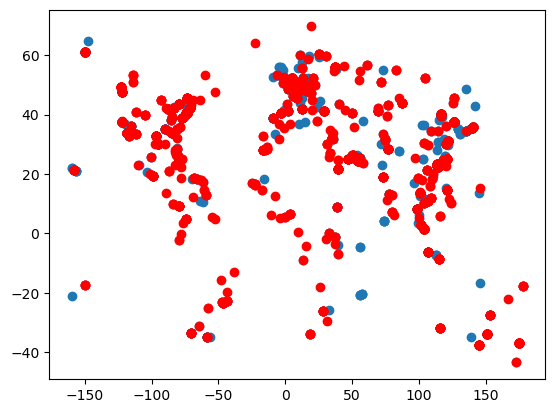

In [36]:
import contextily
fig, ax = plt.subplots()
ax.plot(flights_info_airports.longitude_origin,flights_info_airports.latitude_origin, 'o')
ax.plot(flights_info_airports.longitude_destination,flights_info_airports.latitude_destination, 'o',color="red")
contextily.add_basemap(ax, crs=countries.crs)

plt.show()

In [81]:
from shapely.geometry import Point
from pyproj import Geod

# Define WGS84 ellipsoid
geod = Geod(ellps="WGS84")

# Define the coordinates of the cities
paris = Point(2.3522, 48.8566)  # Longitude, Latitude (Paris)
new_york = Point(-74.0060, 40.7128)  # Longitude, Latitude (New York)

# Calculate the geodesic distance
lon1, lat1 = paris.x, paris.y
lon2, lat2 = new_york.x, new_york.y
distance = geod.inv(lon1, lat1, lon2, lat2)[2] / 1000  # Distance in kilometers

print(f"Distance between Paris and New York: {distance:.2f} km")


Distance between Paris and New York: 5852.94 km


In [82]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

def localisation(longitude, latitude):
    """
    Create point geometries from longitude and latitude data.

    Parameters:
    -----------
    longitude : pd.Series
        Series containing longitude values.
    latitude : pd.Series
        Series containing latitude values.

    Returns:
    --------
    gpd.GeoSeries
        GeoSeries containing the point geometries in EPSG:3857 projection.
    """
    # Create Point geometries, handling missing data
    points = [
        Point(lon, lat) if pd.notna(lon) and pd.notna(lat) else None
        for lon, lat in zip(longitude, latitude)
    ]
    
    # Convert to GeoSeries with WGS84 CRS
    coord_airport = gpd.GeoSeries(points, crs="EPSG:4326")
    
    # Transform to Web Mercator CRS
    coord_airport = coord_airport.to_crs("EPSG:3857")
    
    return coord_airport

# Calculate distances
origin_coord = localisation(flights_info_airports.longitude_origin, flights_info_airports.latitude_origin)
destination_coord = localisation(flights_info_airports.longitude_destination, flights_info_airports.latitude_destination)

# Ensure CRS consistency before distance computation
if origin_coord.crs != destination_coord.crs:
    raise ValueError("CRS mismatch between origin and destination coordinates.")

# Compute distances (in kilometers)
flights_info_airports["distance"] = origin_coord.distance(destination_coord) / 1000
flights_info_airports.loc[:,["city_origin", "country_origin", "city_destination", "country_destination", "distance"]].\
    sort_values("distance", ascending=False).dropna()

,city_origin,country_origin,city_destination,country_destination,distance
991,Honolulu,United States,Sydney,Australia,35008.618238
492,Sydney,Australia,Honolulu,United States,35008.618238
629,Vancouver,Canada,Auckland,New Zealand,34868.400903
795,Auckland,New Zealand,Vancouver,Canada,34868.400903
139,Vancouver,Canada,Auckland,New Zealand,34868.400903
...,...,...,...,...,...
511,Kish Island,Iran,Teheran,Iran,1229.905088
821,Yangon,Burma,Myitkyina,Burma,1021.943219
659,Xining,China,Chengdu,China,823.078027
13,Washington,United States,Raleigh-durham,United States,459.993398


In [ ]:
# Importing the great_circle module from the library 
from geopy.distance import great_circle 
  
# Loading the lat-long data for Kolkata & Delhi 
#kolkata = (22.5726, 88.3639) 
#delhi = (28.7041, 77.1025)
origin=zip(flights_info_airports.latitude_origin, flights_info_airports.longitude_origin)
destination=zip(flights_info_airports.latitude_destination, flights_info_airports.longitude_destination)
  
# Print the distance calculated in km 
print(great_circle(origin, destination).km) 

ValueError: When creating a Point from sequence, it must not have more than 3 items.

In [113]:
def calculate_flight_distances(df):
    """
    Calculate great circle distances between origin and destination airports
    
    Parameters:
    df: DataFrame with columns latitude_origin, longitude_origin, 
        latitude_destination, longitude_destination
    
    Returns:
    Series containing distances in kilometers
    """
    distances = []
    
    for idx, row in df.iterrows():
        origin = (row['latitude_origin'], row['longitude_origin'])
        destination = (row['latitude_destination'], row['longitude_destination'])
        distance = great_circle(origin, destination).km
        distances.append(distance)
    
    return pd.Series(distances)

In [114]:
flights_info_airports['distance_km'] = calculate_flight_distances(flights_info_airports)

ValueError: Point coordinates must be finite. (nan, nan, 0.0) has been passed as coordinates.

In [115]:
import pandas as pd
import numpy as np
from geopy.distance import great_circle

def calculate_flight_distances(df):
    """
    Calculate great circle distances between origin and destination airports,
    handling NaN values in coordinates.
    
    Parameters:
    df: DataFrame with columns latitude_origin, longitude_origin, 
        latitude_destination, longitude_destination
    
    Returns:
    Series containing distances in kilometers, with NaN for invalid coordinates
    """
    distances = []
    
    for idx, row in df.iterrows():
        # Check if any coordinate is NaN
        coords = [
            row['latitude_origin'], 
            row['longitude_origin'],
            row['latitude_destination'], 
            row['longitude_destination']
        ]
        
        if any(pd.isna(coord) for coord in coords):
            distances.append(np.nan)
            continue
            
        try:
            origin = (row['latitude_origin'], row['longitude_origin'])
            destination = (row['latitude_destination'], row['longitude_destination'])
            distance = great_circle(origin, destination).km
            distances.append(distance)
        except ValueError as e:
            print(f"Error calculating distance for row {idx}: {e}")
            distances.append(np.nan)
    
    return pd.Series(distances, index=df.index)

In [ ]:
# Calculate distances
flights_info_airports['distance_km'] = calculate_flight_distances(flights_info_airports)

flights_info_airports.loc[:,["city_origin", "country_origin", "city_destination", "country_destination", "distance_km"]].\
    sort_values("distance_km", ascending=False).dropna()

,city_origin,country_origin,city_destination,country_destination,distance_km
186,New York,United States,Singapore,Singapore,15340.580177
239,Singapore,Singapore,New York,United States,15340.580177
164,Auckland,New Zealand,Doha,Qatar,14534.198658
6,Doha,Qatar,Auckland,New Zealand,14534.198658
1247,London,United Kingdom,Perth,Australia,14508.332116
...,...,...,...,...,...
200,Albany,United States,Charlotte,United States,1039.754236
821,Yangon,Burma,Myitkyina,Burma,950.936914
659,Xining,China,Chengdu,China,684.577414
13,Washington,United States,Raleigh-durham,United States,365.094149
